### 1 ) 라이브러리 호출 및 데이터 호출

In [1]:
import tensorflow
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2

import numpy as np

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 197463


,eng,fra,cc
170618,"Fortunately, Tom is a different person now.","Heureusement, Tom est une autre personne maint...",CC-BY 2.0 (France) Attribution: tatoeba.org #7...
19635,Is your dog mean?,Ton chien est-il méchant ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
66085,People want to own land.,Les gens veulent posséder des terres.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
58941,She is cooking for him.,Elle est en train de cuisiner pour lui.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
90414,There is a bag on the desk.,Il y a un sac sur le bureau.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
27268,We're journalists.,Nous sommes journalistes.
12580,We're grateful.,Nous sommes reconnaissants.
19830,It's really cold.,Il fait vraiment très froid.
25153,It's all the rage.,C'est la folie.
27151,We need more data.,Il nous faut plus de données.


In [4]:
lines['eng']

0                        Go.
1                        Go.
2                        Go.
3                        Go.
4                        Hi.
                ...         
32995    We all cried a lot.
32996    We all felt hungry.
32997    We also found this.
32998    We are busy people.
32999    We are watching TV.
Name: eng, Length: 33000, dtype: object

### 2 ) Step 1. 정제, 정규화, 전처리

#### 구두점과 단어 분리

In [5]:
PUNCTUATION_REGEX = r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]'

In [6]:
lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)

In [7]:
lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)

In [8]:
lines['eng'] = lines['eng'].str.rstrip()
lines['fra'] = lines['fra'].str.rstrip()

In [9]:
lines['eng'][0]

'Go .'

#### 소문자로 바꾸기

In [10]:
'A is B'.lower()

'a is b'

In [11]:
lines["eng"] = lines["eng"].str.lower()
lines["fra"] = lines["fra"].str.lower()

#### 프랑스 단어장에 시작 토큰과 끝 토큰 넣기

In [12]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
lines.sample(5)

,eng,fra
16217,tom is drenched .,\t tom est trempé . \n
32824,tom seems startled .,\t tom semble surpris . \n
10130,he is an actor .,\t c ' est un acteur . \n
30162,i sat on the floor .,\t je me suis assise par terre . \n
26971,tom was very busy .,\t tom était très occupé . \n


#### 띄어쓰기 단위로 토크나이저 적용

In [13]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [14]:
eng_tokenizer = Tokenizer(filters = ' ') 
eng_tokenizer.fit_on_texts(lines.eng)
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [15]:
fra_tokenizer = Tokenizer(filters = ' ')   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 76, 10, 2], [1, 345, 3, 2], [1, 27, 486, 10, 2]]

#### 단어장의 크기 변수로 지정

In [16]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4713
프랑스어 단어장의 크기 : 9467


#### 문장 최대 길이 변수로 지정

In [17]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [18]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4713
프랑스어 단어장의 크기 : 9467
영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [19]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [20]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 10)
프랑스어 입력데이터의 크기(shape) : (33000, 20)
프랑스어 출력데이터의 크기(shape) : (33000, 20)


In [21]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 20)


### 3 ) 모델 생성

In [22]:
from tensorflow.keras.layers import Input, Embedding, Masking

In [23]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [24]:
tf.random.set_seed(42)

embedding_size = 512
hidden_size = 512
# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb_layer = Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)
enc_emb = enc_emb_layer(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout=0.3, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [25]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer =  Embedding(fra_vocab_size, embedding_size)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masked_layer = Masking(mask_value=0.0)
dec_masking = dec_masked_layer(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout=0.3, return_sequences = True, return_state=True, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4))
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [26]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax', kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4))
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [27]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
opt = tf.keras.optimizers.Adam(learning_rate= 1e-3)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2413056     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    4847104     input_2[0][0]                    
______________________________________________________________________________________________

In [28]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,\
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, epochs=30)

Epoch 1/30
118/118 [==============================] - 22s 119ms/step - loss: 2.4108 - accuracy: 0.6947 - val_loss: 2.0169 - val_accuracy: 0.6808
Epoch 2/30
118/118 [==============================] - 12s 101ms/step - loss: 1.5747 - accuracy: 0.7746 - val_loss: 1.6797 - val_accuracy: 0.7688
Epoch 3/30
118/118 [==============================] - 12s 102ms/step - loss: 1.3399 - accuracy: 0.8074 - val_loss: 1.4884 - val_accuracy: 0.7901
Epoch 4/30
118/118 [==============================] - 12s 103ms/step - loss: 1.1963 - accuracy: 0.8248 - val_loss: 1.3862 - val_accuracy: 0.8012
Epoch 5/30
118/118 [==============================] - 12s 105ms/step - loss: 1.1058 - accuracy: 0.8358 - val_loss: 1.3198 - val_accuracy: 0.8071
Epoch 6/30
118/118 [==============================] - 12s 106ms/step - loss: 1.0410 - accuracy: 0.8458 - val_loss: 1.2697 - val_accuracy: 0.8152
Epoch 7/30
118/118 [==============================] - 13s 107ms/step - loss: 0.9908 - accuracy: 0.8537 - val_loss: 1.2205 - val_ac

In [29]:
history_dict = history.history

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [31]:
import matplotlib.pyplot as plt

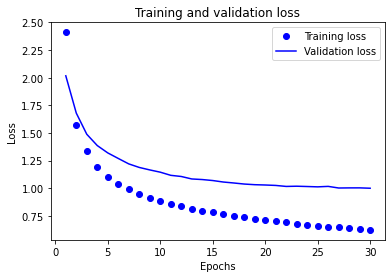

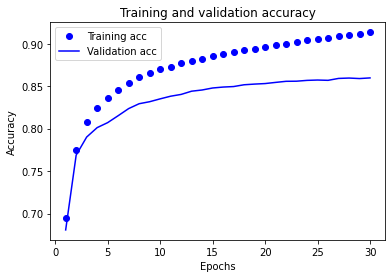

In [32]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4 ) 모델 평가하기

In [33]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [34]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         2413056   
_________________________________________________________________
masking (Masking)            (None, None, 512)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 2099200   
Total params: 4,512,256
Trainable params: 4,512,256
Non-trainable params: 0
_________________________________________________________________


In [35]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
dec_masked2 = dec_masked_layer(dec_emb2)
decoder_outputs2, state_h, state_c = decoder_lstm(dec_masked2, initial_state=decoder_states_inputs)
decoder_states=[state_h, state_c]
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    4847104     input_2[0][0]                    
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 512)    0           embedding_1[1][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [36]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [49]:
import numpy as np
for seq_index in np.random.randint(0, 10000, 5): # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: remain seated .
정답 문장:  reste assis . 
번역기가 번역한 문장:  restez assise . 
-----------------------------------
입력 문장: they ' re weak .
정답 문장:  elles sont faibles . 
번역기가 번역한 문장:  ils sont . 
-----------------------------------
입력 문장: i ' m confused .
정답 문장:  je suis confus . 
번역기가 번역한 문장:  je suis confus . 
-----------------------------------
입력 문장: who hired you ?
정답 문장:  qui t ' a recrutée  ? 
번역기가 번역한 문장:  qui vous a envoyé ? 
-----------------------------------
입력 문장: he is a dj .
정답 문장:  il est dj . 
번역기가 번역한 문장:  il est aux train de mange


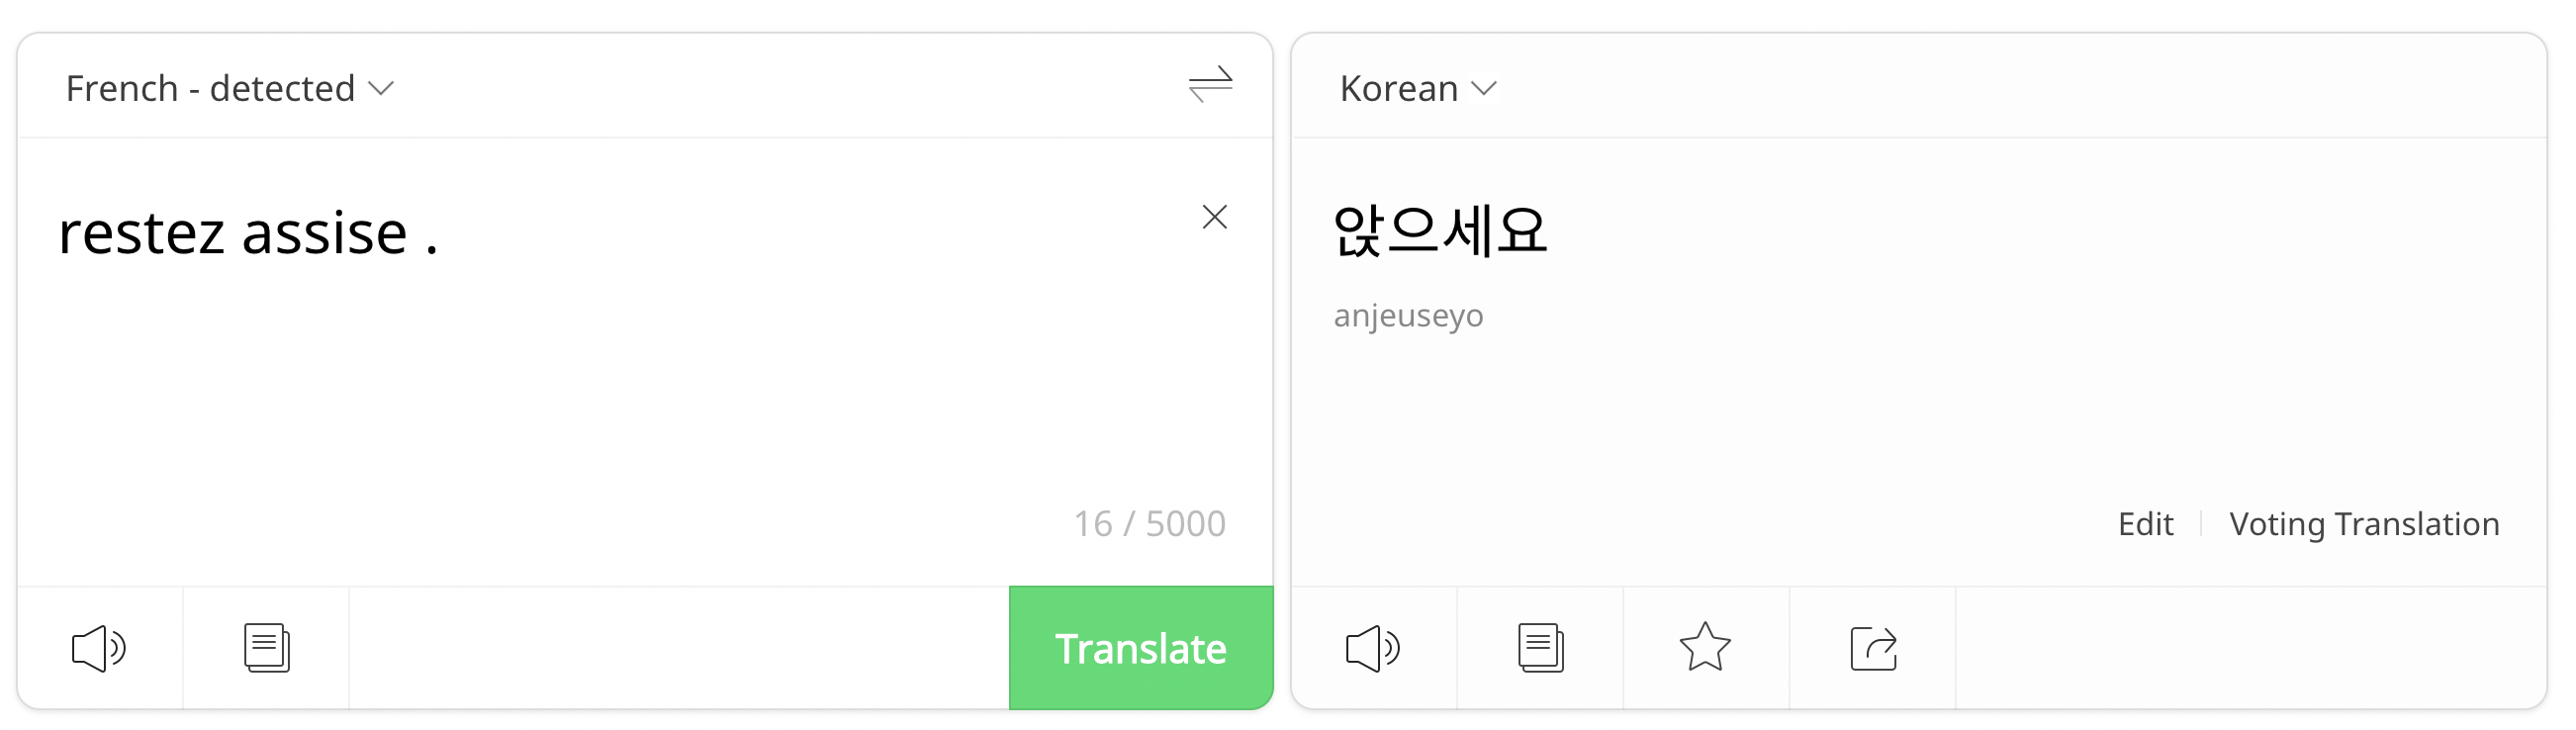

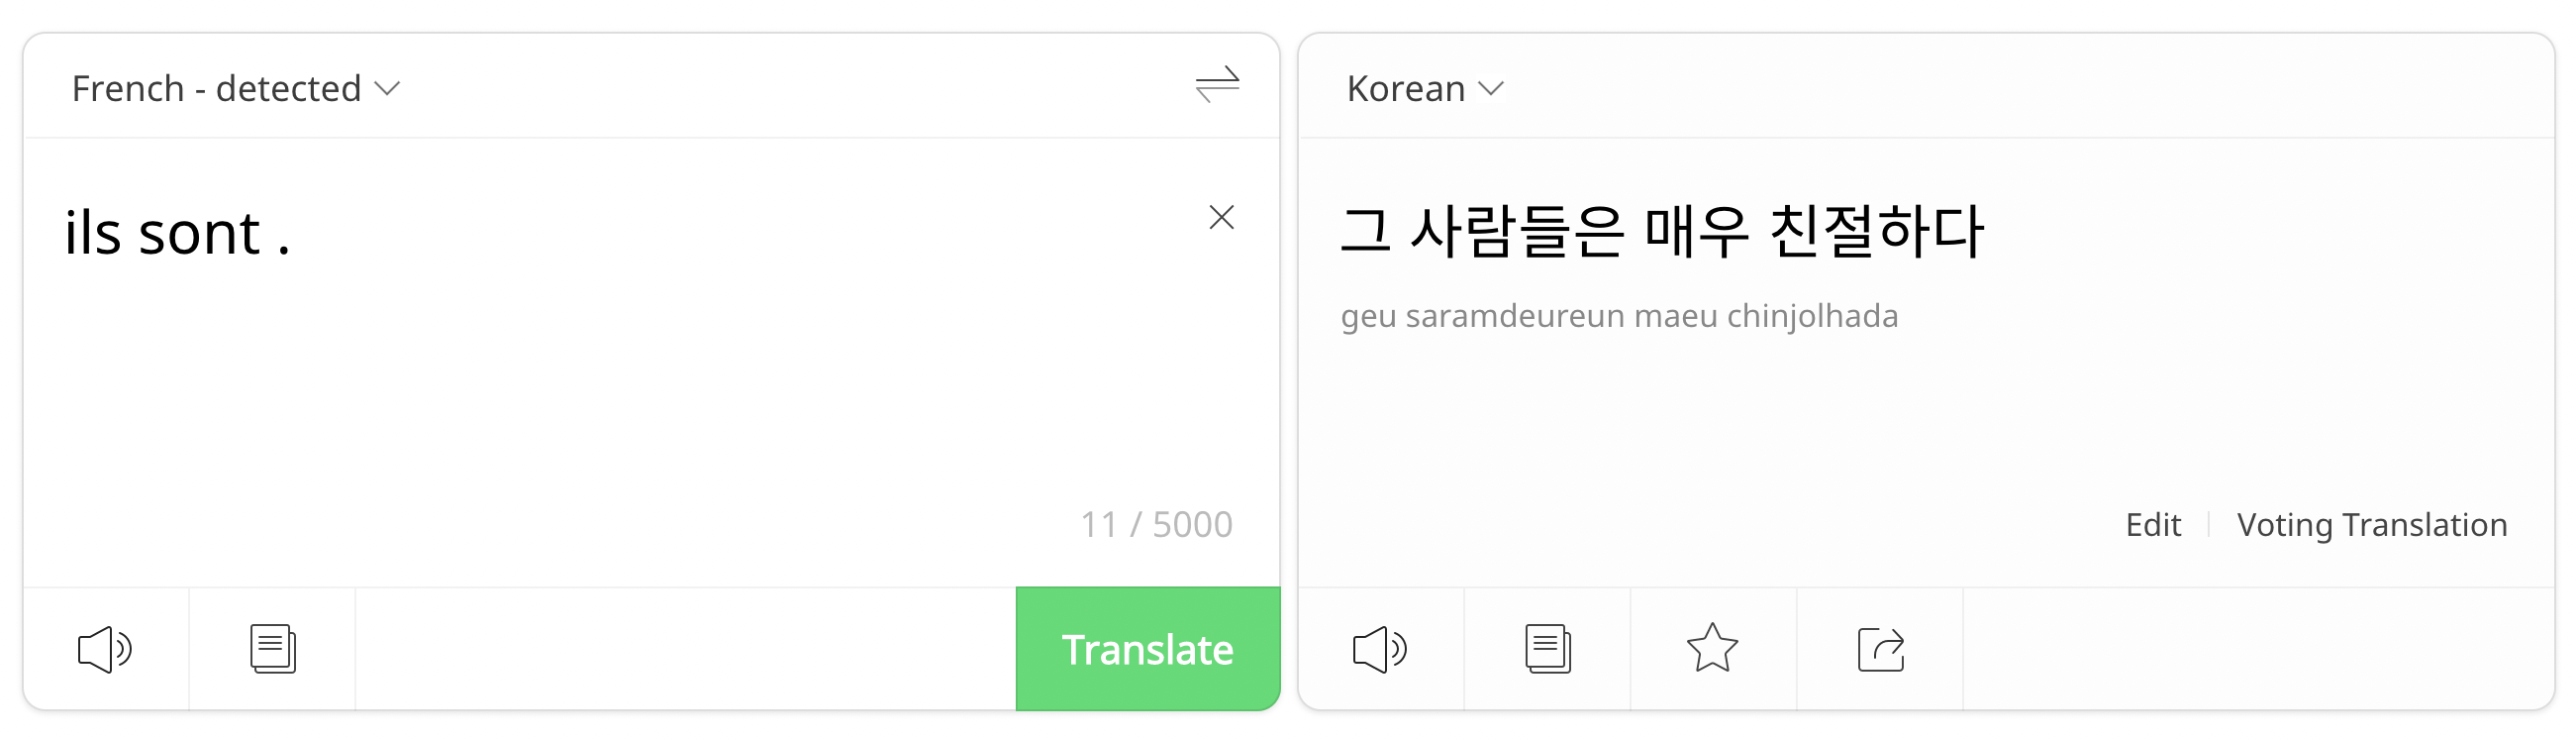

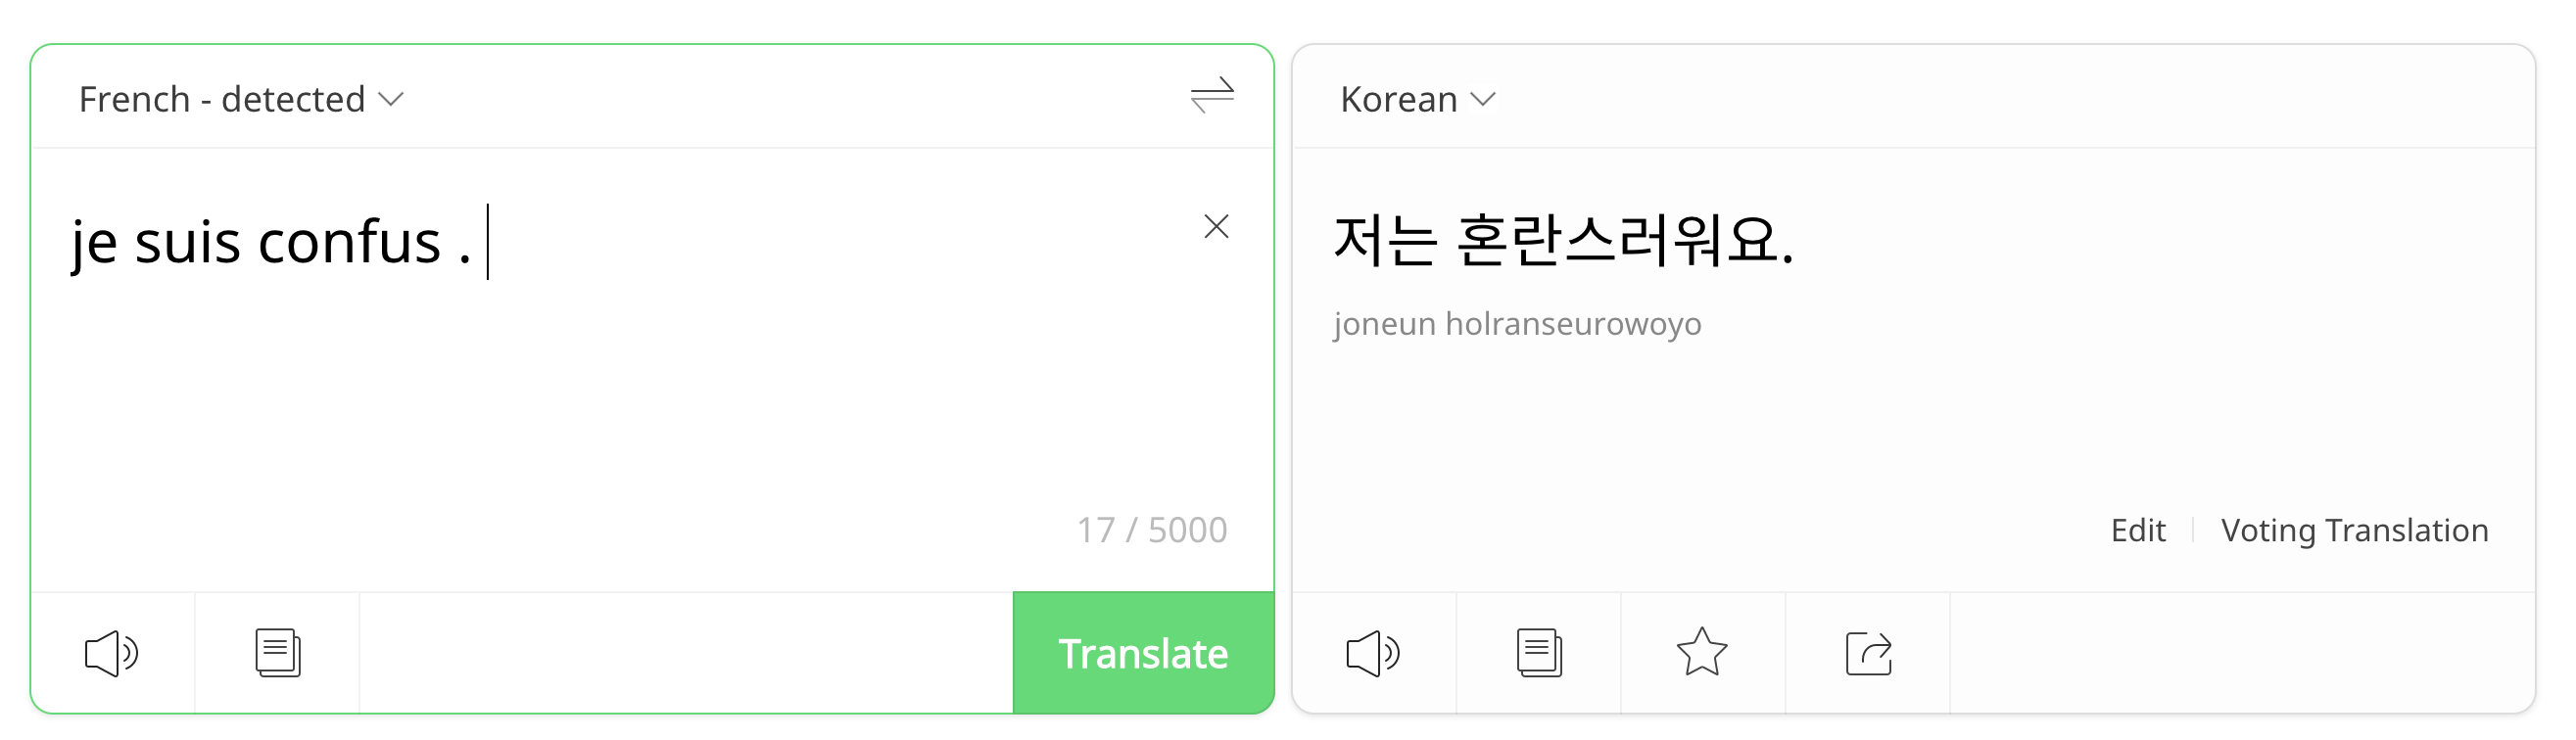

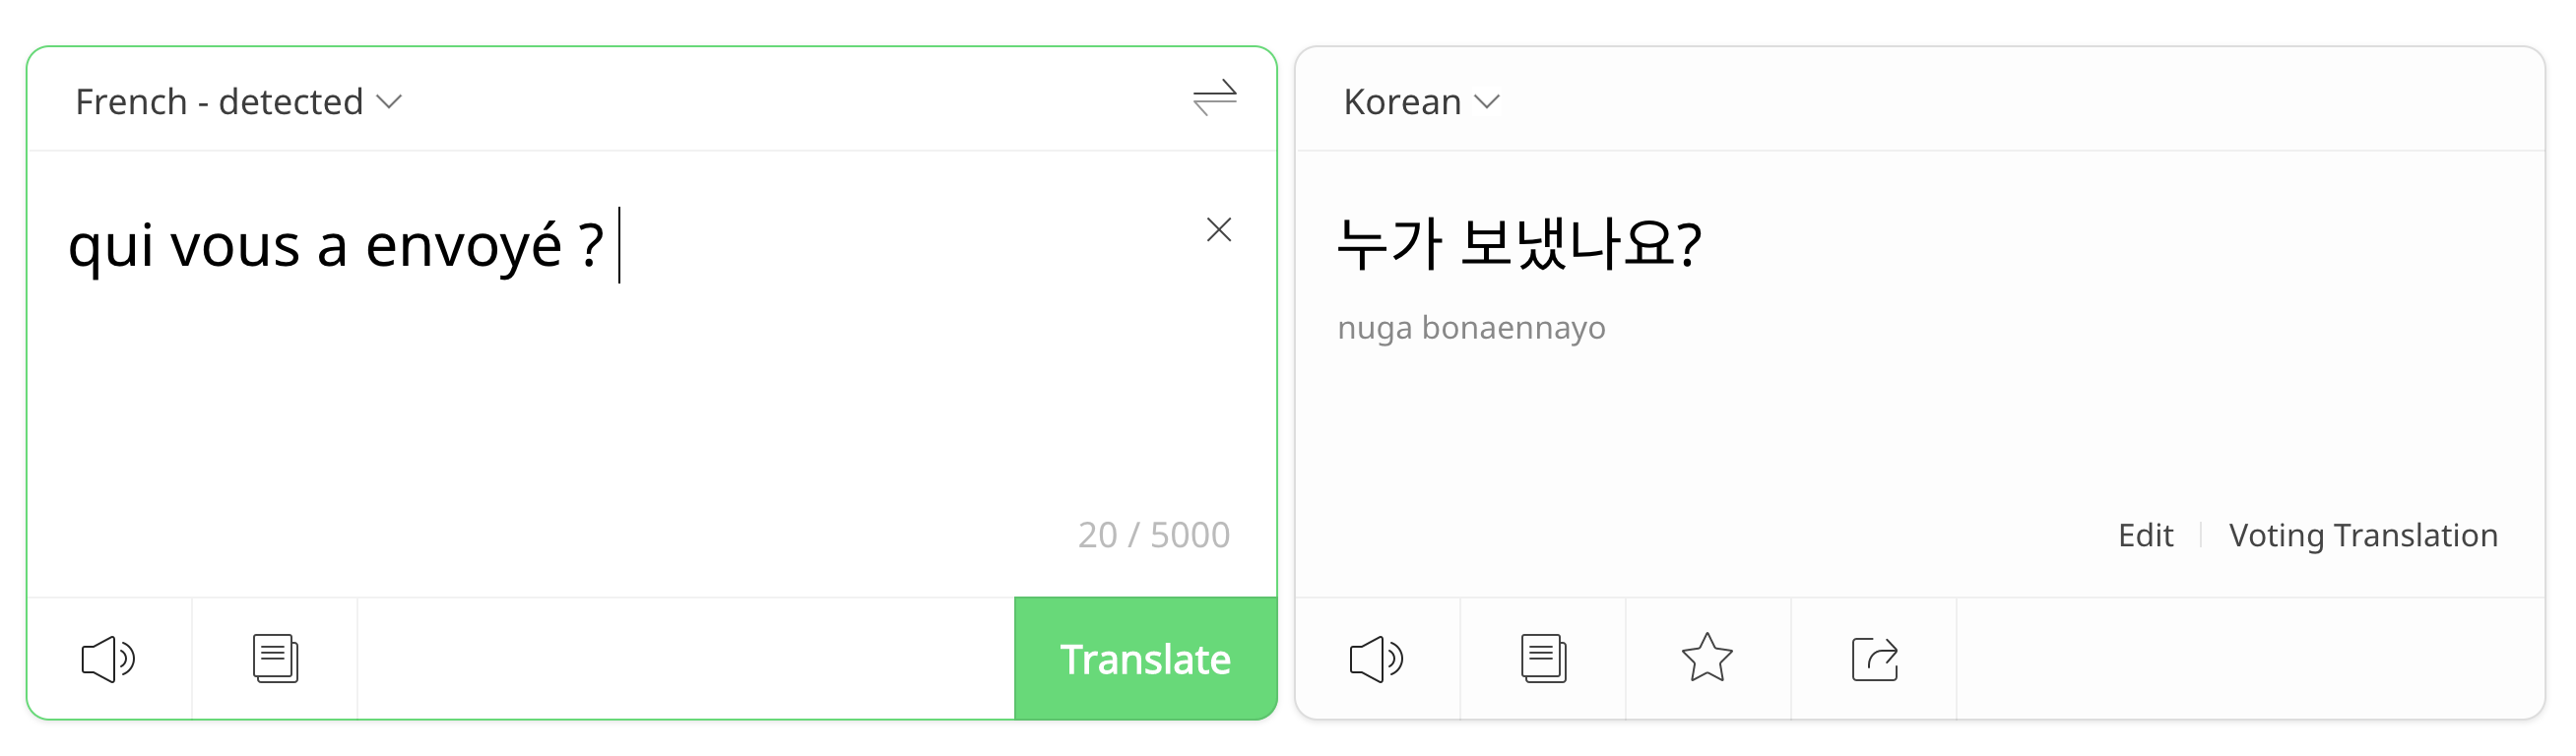

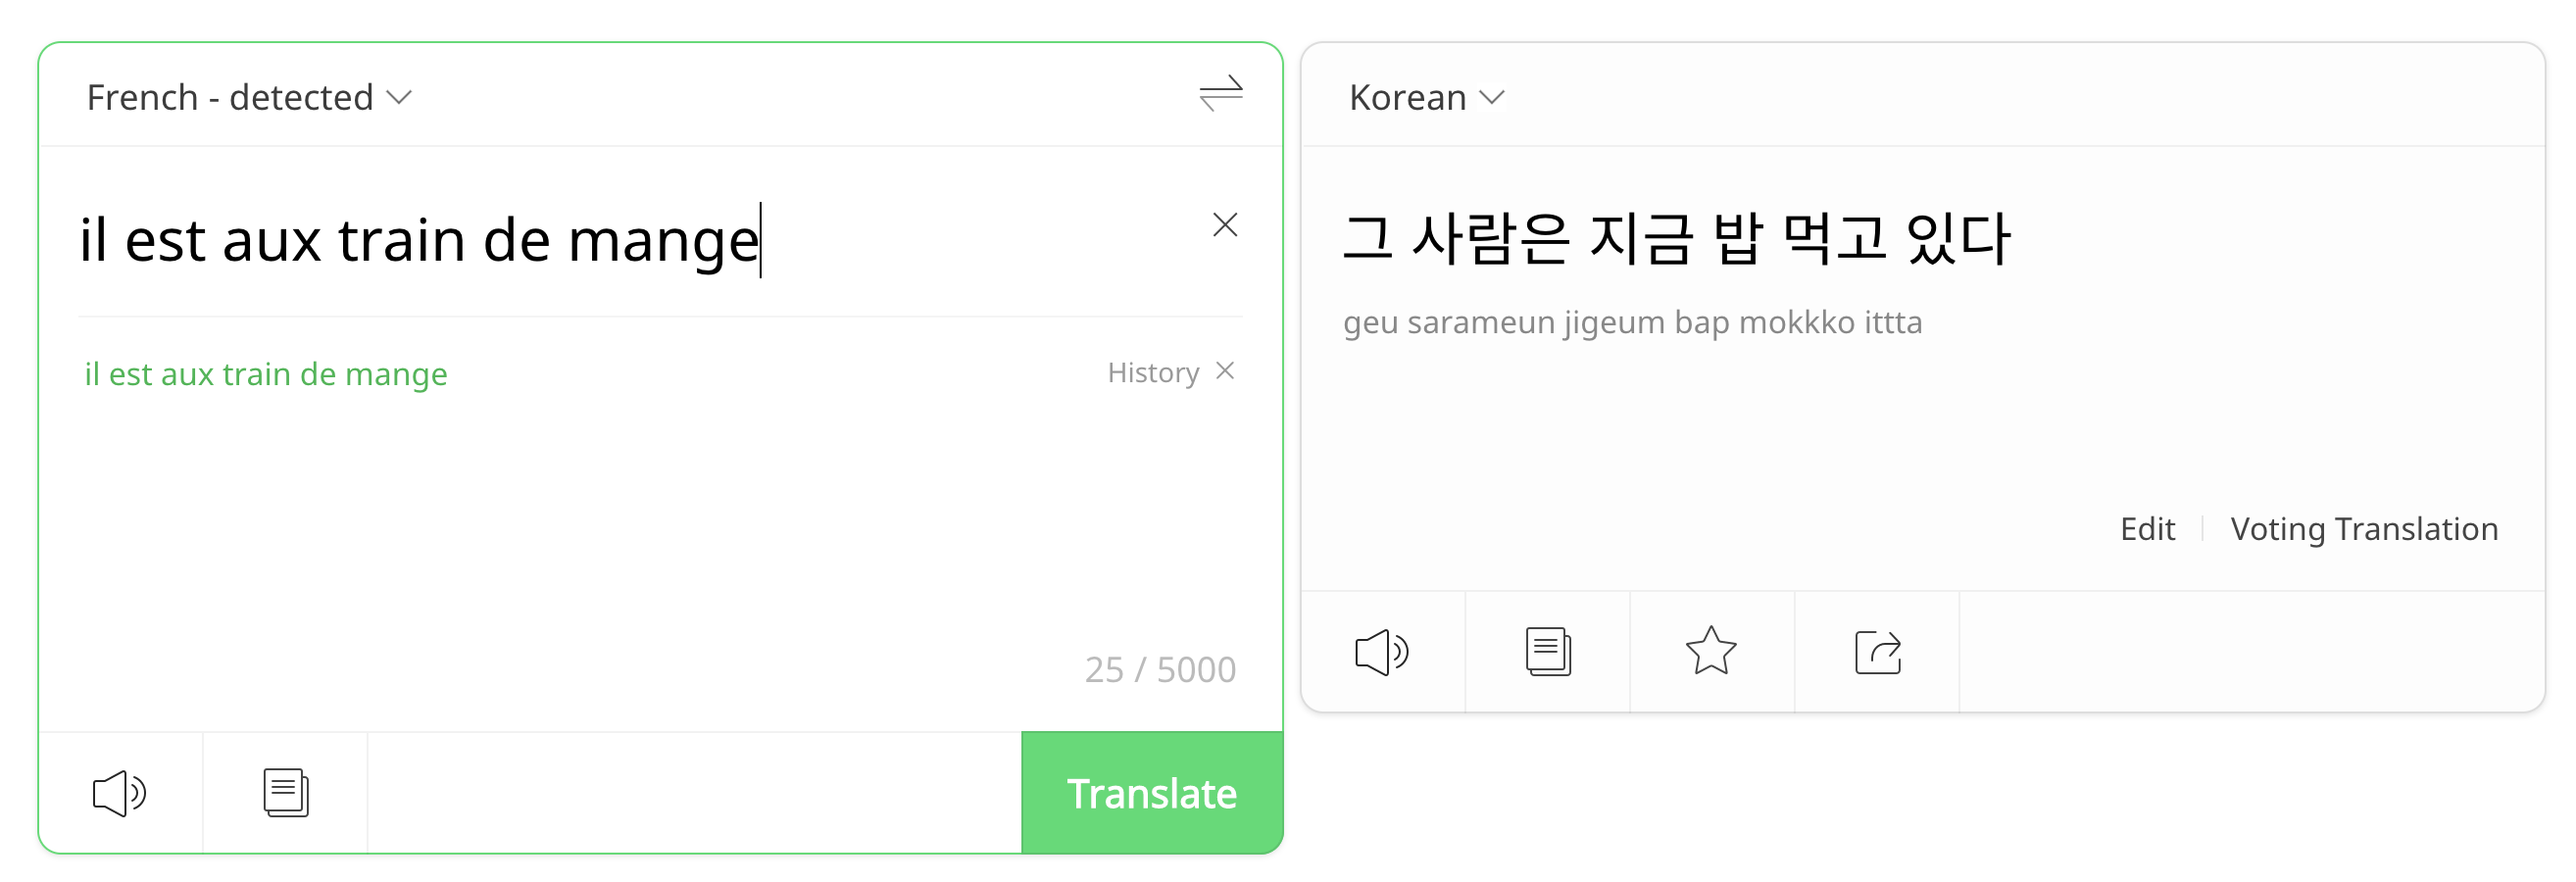

### 5 ) 회고

#### Encoding LSTM에서 나오는 hidden state들이 번역을 가능케하는 핵심 정보인 거 같은데 의미를 분석해 볼 계획이다. 
#### Embedding layer를 직접 학습시키는 것이 아닌 미리 저장되어있는 word2vec등의 모델을 이용하여 학습하면 성능이 더욱 개선될 것이라 예상해 시도해볼 계획이다.